In [1]:
import cv2
import json
import requests
import pathlib
import shutil
import os
import numpy as np
import pandas as pd
import time
import sys
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# South-park Avatar Generator

In this notebook we'll create the south-park avatar generator.  
The code will also be copy-pasted into the .py file

(note that not all all the categories are finished)

In [2]:
class SouthParkAvatarGenerator:
    def __init__(self, images_path = 'images'):
        self.images_path = images_path
        
        #-------------------#
        # Init the colours  #
        #-------------------#
        # skin colour properties
        self.skin_colours = [(254, 218, 181), (253, 203, 162), (213, 168, 125), (119, 95, 79), (231, 156, 113)]
        self.skin_colours_proba = [0.35, 0.25, 0.15, 0.15, 0.1]
        self.skin_colour = None
        
        # hair colour 
        self.hair_colours = [(230, 230, 230), (132, 111, 88), (250, 255, 65), (204, 153, 51), (255, 151, 63), (22, 19, 22), (93, 67, 48), (142, 82, 2), (149, 99, 27), (136, 119, 107), (131, 118, 119)]
        self.hair_colours_proba = np.ones(len(self.hair_colours))/len(self.hair_colours)
        self.hair_colour = None
        
        # beard color
        self.beard_colours = [(230, 230, 230), (132, 111, 88), (250, 255, 65), (204, 153, 51), (255, 151, 63), (22, 19, 22), (93, 67, 48), (142, 82, 2), (149, 99, 27), (136, 119, 107), (131, 118, 119)]
        self.beard_colours_proba = np.ones(len(self.beard_colours))/len(self.beard_colours)
        self.beard_colour = None
        
        # shirt color
        self.shirt_colours = [(63, 56, 68),(240, 243, 242),(81, 24, 73),(199, 0, 57),(249, 81, 53),(255, 141, 26),(255, 195, 0),(237, 221, 83),(173, 212, 92),(87, 199, 133),(0, 186, 173),(42, 123, 155)]
        self.shirt_colours_proba = np.ones(len(self.shirt_colours))/len(self.shirt_colours)
        self.shirt_colour = None
        
        #----------#
        # Required #
        #----------#
        # body_parts
        self.body_parts = self.get_body_parts()        

        # eyes
        self.eyes = self.read_single_pngs('eyes')
        self.eyes_proba = np.ones(len(self.eyes))/len(self.eyes) # an equal chance for everyone
        self.eye = None
        
        # mouth
        self.mouths = self.read_single_pngs('mouth')
        self.mouths_proba = np.ones(len(self.mouths))/len(self.mouths) # an equal chance for everyone
        self.mouth = None
        
        # shirt
        self.shirts = self.read_single_pngs('shirt')
        self.shirts_proba = np.ones(len(self.shirts))/len(self.shirts) # an equal chance for everyone
        self.shirt = None
        
        # trousers
        self.trousers = self.read_single_pngs('trousers')
        self.trousers_proba = np.ones(len(self.trousers))/len(self.trousers) # an equal chance for everyone
        self.trouser = None
        
        
        #----------#
        # Optional #
        #----------#
        # has hair 
        self.has_hairs = [False, True]
        self.has_hairs_proba = [0.1, 0.9]
        self.has_hair = None
        
        # has glasses 
        self.has_glasses_ = [False, True]
        self.has_glasses_proba = [0.5, 0.5]
        self.has_glasses = None
        
        # has beard 
        self.has_beards = [False, True]
        self.has_beards_proba = [0.5, 0.5]
        self.has_beard = None
        
        # has item 
        self.has_items = [False, True]
        self.has_items_proba = [0.5, 0.5]
        self.has_item = None
        
        # has hats 
        self.has_hats = [False, True]
        self.has_hats_proba = [0.5, 0.5]
        self.has_hat = None
        
        # has jewellery 
        self.has_jewellies = [False, True]
        self.has_jewellies_proba = [0.5, 0.5]
        self.has_jewellery = None
        
        # has pin 
        self.has_pins = [False, True]
        self.has_pins_proba = [0.5, 0.5]
        self.has_pin = None
        
        
        
        #----------------#
        # Optional items #
        #----------------#
        # hair
        self.hairs = self.read_single_pngs('hair')
        self.hairs_proba = np.ones(len(self.hairs))/len(self.hairs) # an equal chance for everyone
        self.hair = None
        
        # glasses
        self.glasses = self.read_single_pngs('glasses')
        self.glasses_proba = np.ones(len(self.glasses))/len(self.glasses) # an equal chance for everyone
        self.glass = None
        
        
        # beards
        self.beards = self.read_single_pngs('beards')
        self.beards_proba = np.ones(len(self.beards))/len(self.beards) # an equal chance for everyone
        self.beard = None
        
        
        # items
        self.items = self.read_single_pngs('items')
        self.items_proba = np.ones(len(self.items))/len(self.items) # an equal chance for everyone
        self.item = None
                
        # hats
        self.hats = self.read_single_pngs('hats')
        self.hats_proba = np.ones(len(self.hats))/len(self.hats) # an equal chance for everyone
        self.hat = None
                
        # jewelry
        self.jewellery = self.read_single_pngs('jewellery')
        self.jewellery_proba = np.ones(len(self.jewellery))/len(self.jewellery) # an equal chance for everyone
        self.jewel = None
        
        # pins
        self.pins = self.read_single_pngs('pins')
        self.pins_proba = np.ones(len(self.pins))/len(self.pins) # an equal chance for everyone
        self.pin = None
             
            
            
    def set_property(self, property_values, property_proba, property_value, index):
        # this function wiill set the properties for a certain item
        
        prop_values = getattr(self, property_values)
        prop_value = getattr(self, property_value)
        prop_proba = getattr(self, property_proba)
        
        if type(index) == int and index >= 0 and index < len(prop_proba):
            prop_value = prop_values[index]
        else:
            prop_value = prop_values[np.random.choice(len(prop_proba), 1, p=prop_proba)[0]]
            
        setattr(self, property_value, prop_value)
        return prop_value
    
    def read_single_pngs(self, obj):
        # temporary
        imgs = []
        for folder in os.listdir(f'{self.images_path}/{obj}'):
            img_dict = {'fg':[]}
            for img in os.listdir(f'{self.images_path}/{obj}/{folder}'):
                if 'bg' in img:
                    if 'bg' not in img_dict:
                        img_dict['bg'] = []
                    img_dict['bg'].append( np.array(Image.open(f'{self.images_path}/{obj}/{folder}/{img}')) )
                else:
                    img_dict['fg'].append( np.array(Image.open(f'{self.images_path}/{obj}/{folder}/{img}')) )
            imgs.append(img_dict)
        return imgs
      
    def generate(self, skin_colour = None, 
                       hair_colour = None, 
                       beard_colour = None, 
                       shirt_colour = None,
                       eyes = None, 
                       mouth = None, 
                       shirt = None, 
                       trouser = None,
                       has_hair = None, hair = None,
                       has_glasses = None, glasses = None,
                       has_beard = None, beard = None,
                       has_hat = None, hat = None,
                       has_jewellery = None, jewellery = None,
                       has_item = None, item = None,
                       has_pin = None, pin = None):
        
        #--------------------------------------#
        # Combina all the images into 1 avatar #
        #--------------------------------------#
        
        # generate the attributes
        self.set_skin_colour(skin_colour)
        self.set_hair_colour(hair_colour)
        #self.set_beard_colour(beard_colour)
        self.set_shirt_colour(shirt_colour)
        self.set_eyes(eyes)
        self.set_mouth(mouth)
        self.set_trouser(trouser)
        self.set_shirt(shirt)
        self.set_has_hair(has_hair) 
        self.set_hair(hair)
        self.set_has_glasses(has_glasses)
        self.set_glasses(glasses)
        self.set_has_beard(has_beard) 
        self.set_beard(beard)
        # self.set_has_hat(has_hat)
        # self.set_hat(hat)
        # self.set_has_jewellery(has_jewellery)
        # self.set_jewellery(jewellery)
        # self.set_has_item(has_item)
        # self.set_item(item)
        # self.set_has_pin(has_pin) 
        # self.set_pin(pin)

        #-------------------#
        # generate the body #
        #-------------------#
        
        avatar = Image.fromarray(np.zeros((811, 745, 4)), 'RGBA') 
                
        

        # add underware
        #underware = Image.fromarray(self.body_parts['underware'], 'RGBA')
        #avatar.paste(underware, (0, 0), underware)
        
        # add trouser
        
        #trouser = Image.fromarray(self.get_trouser()[0], 'RGBA')
        #avatar.paste(trouser, (0, 0), trouser)
        
        # add shirt
        #shirt = Image.fromarray(self.get_shirt()[0], 'RGBA')
        #avatar.paste(shirt, (0, 0), shirt)
        
        
        # add background hair
        if self.has_hair:
            hair = self.get_hair()
            for e, bg_hair in enumerate(hair.get('bg', [])):
                if e == 0:
                    bg_hair[:,:,0][bg_hair[:,:,0] == 255] = self.hair_colour[0]
                    bg_hair[:,:,1][bg_hair[:,:,1] == 255] = self.hair_colour[1]
                    bg_hair[:,:,2][bg_hair[:,:,2] == 255] = self.hair_colour[2]
                bg_hair = Image.fromarray(bg_hair, 'RGBA') 
                avatar.paste(bg_hair, (0, 0), bg_hair)

        # grep the body
        body = self.body_parts['body']
        body[:,:,0][body[:,:,0] > 0] = self.skin_colour[0]
        body[:,:,1][body[:,:,1] > 0] = self.skin_colour[1]
        body[:,:,2][body[:,:,2] > 0] = self.skin_colour[2]
        avatar = Image.fromarray(body, 'RGBA') 
    
        # add arms
        arms = Image.fromarray(self.body_parts['arms'], 'RGBA')
        avatar.paste(arms, (0, 0), arms)
    
        # add the trousers
        trouser = self.get_trouser()
        trouser_col = np.random.randint(-50,50, size=1)[0]
        
        for e, bg_trouser in enumerate(trouser.get('bg', [])):
            
            bg_trouser[:,:,0][bg_trouser[:,:,0] == 255] = max(min(self.shirt_colour[0] + trouser_col, 250),10)
            bg_trouser[:,:,1][bg_trouser[:,:,1] == 255] = max(min(self.shirt_colour[1] + trouser_col, 250),10)
            bg_trouser[:,:,2][bg_trouser[:,:,2] == 255] = max(min(self.shirt_colour[2] + trouser_col, 250),10)
            bg_trouser = Image.fromarray(bg_trouser, 'RGBA') 
            avatar.paste(bg_trouser, (0, 0), bg_trouser)
            
        for e, fg_trouser in enumerate(trouser.get('fg', [])):
            fg_trouser = Image.fromarray(fg_trouser, 'RGBA') 
            avatar.paste(fg_trouser, (0, 0), fg_trouser)
            
            
        # add the t-shirt
        shirt = self.get_shirt()
        for e, bg_shirt in enumerate(shirt.get('bg', [])):
            
            bg_shirt[:,:,0][bg_shirt[:,:,0] == 255] = self.shirt_colour[0]
            bg_shirt[:,:,1][bg_shirt[:,:,1] == 255] = self.shirt_colour[1]
            bg_shirt[:,:,2][bg_shirt[:,:,2] == 255] = self.shirt_colour[2]
            bg_shirt = Image.fromarray(bg_shirt, 'RGBA') 
            avatar.paste(bg_shirt, (0, 0), bg_shirt)
            
        for e, fg_shirt in enumerate(shirt.get('fg', [])):
            fg_shirt = Image.fromarray(fg_shirt, 'RGBA') 
            avatar.paste(fg_shirt, (0, 0), fg_shirt)


        # add the head
        head = self.body_parts['head']
        head[:,:,0][head[:,:,0] > 0]  = self.skin_colour[0]
        head[:,:,1][head[:,:,1] > 0] = self.skin_colour[1]
        head[:,:,2][head[:,:,2] > 0] = self.skin_colour[2]
        head = Image.fromarray(head, 'RGBA') 
        avatar.paste(head, (0, 0), head)

        

        
        # add chin
        chin = Image.fromarray(self.body_parts['chin'], 'RGBA')
        avatar.paste(chin, (0, 0), chin)
        
        
                
        # add beard
        if self.has_beard:
            beard = self.get_beard()
            beard_col = np.random.randint(0,50, size=1)[0]
            for e, beard_fg in enumerate(beard.get('fg', [])):
                if e == 0:
                    beard_fg[:,:,0][beard_fg[:,:,0] == 255] = np.min([self.hair_colour[0] + beard_col,  254])
                    beard_fg[:,:,1][beard_fg[:,:,1] == 255] = np.min([self.hair_colour[1] + beard_col,  254])
                    beard_fg[:,:,2][beard_fg[:,:,2] == 255] = np.min([self.hair_colour[2] + beard_col,  254])
                beard_fg = Image.fromarray(beard_fg, 'RGBA') 
                avatar.paste(beard_fg, (0, 0), beard_fg)
                
                
        # add feet
        feet = Image.fromarray(self.body_parts['feet'], 'RGBA')
        avatar.paste(feet, (0, 0), feet)
        
        # add hands
        if self.has_item:
            # background
            hands_bg = self.body_parts['hands_item_bg']
            hands_bg[:,:,0][hands_bg[:,:,0] == 255]  = self.skin_colour[0]
            hands_bg[:,:,1][hands_bg[:,:,1] == 255] = self.skin_colour[1]
            hands_bg[:,:,2][hands_bg[:,:,2] == 255] = self.skin_colour[2]
            hands_bg = Image.fromarray(hands_bg, 'RGBA') 
            avatar.paste(hands_bg, (0, 0), hands_bg)
            
            # foreground
            hands_fg = Image.fromarray(self.body_parts['hands_item_fg'], 'RGBA')
            avatar.paste(hands_fg, (0, 0), hands_fg)
        else:
            # background
            hands_bg = self.body_parts['hands_bg']
            hands_bg[:,:,0][hands_bg[:,:,0] > 0]  = self.skin_colour[0]
            hands_bg[:,:,1][hands_bg[:,:,1] > 0] = self.skin_colour[1]
            hands_bg[:,:,2][hands_bg[:,:,2] > 0] = self.skin_colour[2]
            hands_bg = Image.fromarray(hands_bg, 'RGBA') 
            avatar.paste(hands_bg, (0, 0), hands_bg)
            
            # foreground
            hands_fg = Image.fromarray(self.body_parts['hands_fg'], 'RGBA')
            avatar.paste(hands_fg, (0, 0), hands_fg)
            
        # add eyes
        eyes = Image.fromarray(self.get_eyes().get('fg')[0], 'RGBA')
        avatar.paste(eyes, (0, 0), eyes)

        
        # add mouth
        mouth = Image.fromarray(self.get_mouth().get('fg')[0], 'RGBA')
        avatar.paste(mouth, (0, 0), mouth)

        if self.has_glasses:
            glasses = Image.fromarray(self.get_glasses().get('fg')[0], 'RGBA')
            avatar.paste(glasses, (0, 0), glasses)
        
        
        # foreground hair
        if self.has_hair: 
            for e, fg_hair in enumerate(hair.get('fg',[])):
                if e == 0:
                    fg_hair[:,:,0][fg_hair[:,:,0] == 255] = self.hair_colour[0]
                    fg_hair[:,:,1][fg_hair[:,:,1] == 255] = self.hair_colour[1]
                    fg_hair[:,:,2][fg_hair[:,:,2] == 255] = self.hair_colour[2]
                fg_hair = Image.fromarray(fg_hair, 'RGBA') 
                avatar.paste(fg_hair, (0, 0), fg_hair)
            

 
        if self.has_hat:
            hat = Image.fromarray(self.get_hat()[0], 'RGBA')
            avatar.paste(hat, (0, 0), hat)
        
        if self.has_jewellery:
            jewellery = Image.fromarray(self.get_jewellery()[0], 'RGBA')
            avatar.paste(jewellery, (0, 0), jewellery)
        
        if self.has_item:
            item = Image.fromarray(self.get_item()[0], 'RGBA')
            avatar.paste(item, (0, 0), item)
        
        if self.has_pin:
            pin = Image.fromarray(self.get_pin()[0], 'RGBA')
            avatar.paste(pin, (0, 0), pin)
        
        #avatar.thumbnail((646, 702), Image.ANTIALIAS)
        #avatar = avatar.crop((70,80,582,592))
        return avatar

    
    #------------------------------#
    # Get and setters              #
    #------------------------------#
    #------------#
    # body parts #
    #------------#
    def get_body_parts(self):
        body_parts = {}
        body_parts['body'] =  np.array(Image.open(f'{self.images_path}/body/body.png'))
        body_parts['head'] =  np.array(Image.open(f'{self.images_path}/body/head.png'))
        body_parts['chin'] =  np.array(Image.open(f'{self.images_path}/body/chin.png'))
        body_parts['feet'] =  np.array(Image.open(f'{self.images_path}/body/feet.png'))
        body_parts['hands_bg'] =  np.array(Image.open(f'{self.images_path}/body/hands_bg.png'))
        body_parts['hands_fg'] =  np.array(Image.open(f'{self.images_path}/body/hands_fg.png'))
        body_parts['hands_item_bg'] =  np.array(Image.open(f'{self.images_path}/body/hands_item_bg.png'))
        body_parts['hands_item_fg'] =  np.array(Image.open(f'{self.images_path}/body/hands_item_fg.png'))
        body_parts['underware'] =  np.array(Image.open(f'{self.images_path}/body/underware.png'))
        body_parts['arms'] =  np.array(Image.open(f'{self.images_path}/body/arms.png'))
        
        return body_parts
    
    #-------------#
    # skin colour #
    #-------------#
    def set_skin_colour(self, index = None):
        return self.set_property('skin_colours', 'skin_colours_proba', 'skin_colour', index)
  
    def get_skin_colour(self):
        return self.skin_colour
    
    #-------------#
    # hair colour #
    #-------------#
    def set_hair_colour(self, index = None):
        return self.set_property('hair_colours', 'hair_colours_proba', 'hair_colour', index)
  
    def get_hair_colour(self):
        return self.hair_colour
    
    #-------------#
    # beard colour #
    #-------------#
    def set_beard_colour(self, index = None):
        return self.set_property('beard_colours', 'beard_colours_proba', 'beard_colour', index)
  
    def get_beard_colour(self):
        return self.beard_colour
    
    #--------------#
    # shirt colour #
    #--------------#
    def set_shirt_colour(self, index = None):
        return self.set_property('shirt_colours', 'shirt_colours_proba', 'shirt_colour', index)
  
    def get_shirt_colour(self):
        return self.shirt_colour
    
    
    #-------------#
    # eyes        #
    #-------------#
    def set_eyes(self, index = None):
        return self.set_property('eyes', 'eyes_proba', 'eye', index)
  
    def get_eyes(self):
        return self.eye
    
    #-------------#
    # mouth       #
    #-------------#
    def set_mouth(self, index = None):
        return self.set_property('mouths', 'mouths_proba', 'mouth', index)
  
    def get_mouth(self):
        return self.mouth
    
    #-------------#
    # shirt       #
    #-------------#
    def set_shirt(self, index = None):
        return self.set_property('shirts', 'shirts_proba', 'shirt', index)
  
    def get_shirt(self):
        return self.shirt
    
    #-------------#
    # trouser     #
    #-------------#
    def set_trouser(self, index = None):
        return self.set_property('trousers', 'trousers_proba', 'trouser', index)
  
    def get_trouser(self):
        return self.trouser
    
    
    #----------#
    # has hair #
    #----------#
    def set_has_hair(self, index = None):
        return self.set_property('has_hairs', 'has_hairs_proba', 'has_hair', index)
  
    def _has_hair(self):
        return self.has_hair
    
    #------------#
    #   Hair     #
    #------------#
    def set_hair(self, index = None):
        if self.has_hair:
            return self.set_property('hairs', 'hairs_proba', 'hair', index)
  
    def get_hair(self):
        return self.hair
    
    #-------------#
    # has glasses #
    #-------------#
    def set_has_glasses(self, index = None):
        return self.set_property('has_glasses_', 'has_glasses_proba', 'has_glasses', index)
  
    def has_glasses(self):
        return self.has_glasses
    
    #------------#
    #   glasses  #
    #------------#
    def set_glasses(self, index = None):
        if self.has_glasses:
            return self.set_property('glasses', 'glasses_proba', 'glass', index)
  
    def get_glasses(self):
        return self.glass
    
    
    #-----------#
    # has beard #
    #-----------#
    def set_has_beard(self, index = None):
        return self.set_property('has_beards', 'has_beards_proba', 'has_beard', index)
  
    def has_beard(self):
        return self.has_beard
    
    #------------#
    #   Beard    #
    #------------#
    def set_beard(self, index = None):
        if self.has_beard:
            return self.set_property('beards', 'beards_proba', 'beard', index)
  
    def get_beard(self):
        return self.beard
    
    
    #---------#
    # has hat #
    #---------#
    def set_has_hat(self, index = None):
        return self.set_property('has_hats', 'has_hats_proba', 'has_hat', index)
  
    def has_hat(self):
        return self.has_hat
    
    #------------#
    #   hat      #
    #------------#
    def set_hat(self, index = None):
        if self.has_hat:
            return self.set_property('hats', 'hats_proba', 'hat', index)
  
    def get_hat(self):
        return self.hat
    
    
    #-------------------#
    # has has_jewellery #
    #-------------------#
    def set_has_jewellery(self, index = None):
        return self.set_property('has_jewellies', 'has_jewellies_proba', 'has_jewellery', index)
  
    def has_jewellery(self):
        return self.has_jewellery
    
    #-----------#
    # jewellery #
    #-----------#
    def set_jewellery(self, index = None):
        if self.has_jewellery:
            return self.set_property('jewellery', 'jewellery_proba', 'jewel', index)
  
    def get_jewellery(self):
        return self.jewel
    
    #----------#
    # has item #
    #----------#
    def set_has_item(self, index = None):
        return self.set_property('has_items', 'has_items_proba', 'has_item', index)
  
    def has_item(self):
        return self.has_item
    
    #------#
    # item #
    #------#
    def set_item(self, index = None):
        if self.has_item:
            return self.set_property('items', 'items_proba', 'item', index)
  
    def get_item(self):
        return self.item
    
    #----------#
    # has pin #
    #----------#
    def set_has_pin(self, index = None):
        return self.set_property('has_pins', 'has_pins_proba', 'has_pin', index)
  
    def has_pin(self):
        return self.has_pin
    
    #------#
    # pin  #
    #------#
    def set_pin(self, index = None):
        if self.has_pin:
            return self.set_property('pins', 'pins_proba', 'pin', index)
  
    def get_pin(self):
        return self.pin

# Instantiate the class

In [3]:
%%time
spag = SouthParkAvatarGenerator()

Wall time: 5.46 s


# Show an single random avatar

Wall time: 52.8 ms


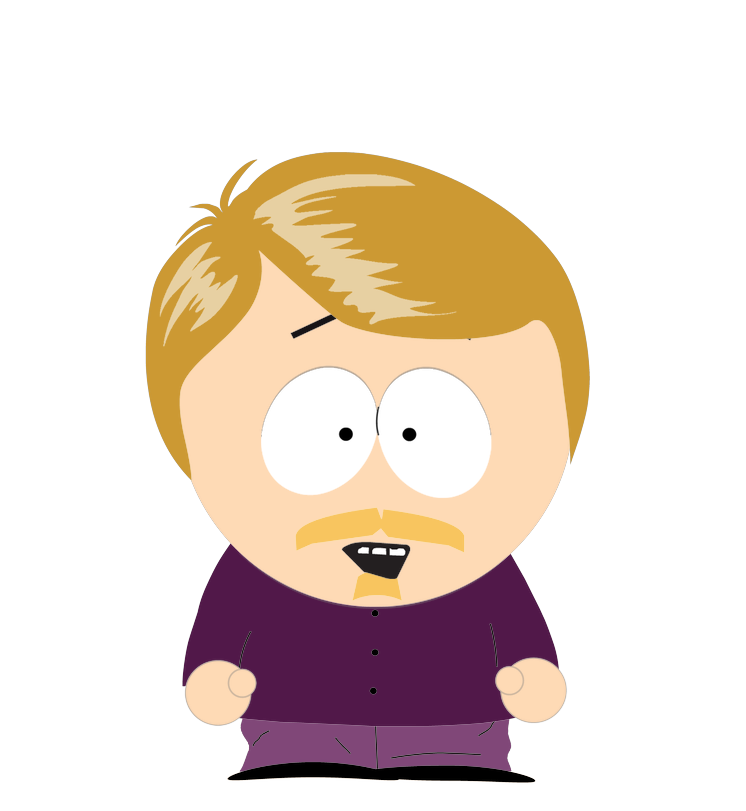

In [4]:
%%time
spag.generate()

# Play with the parameters

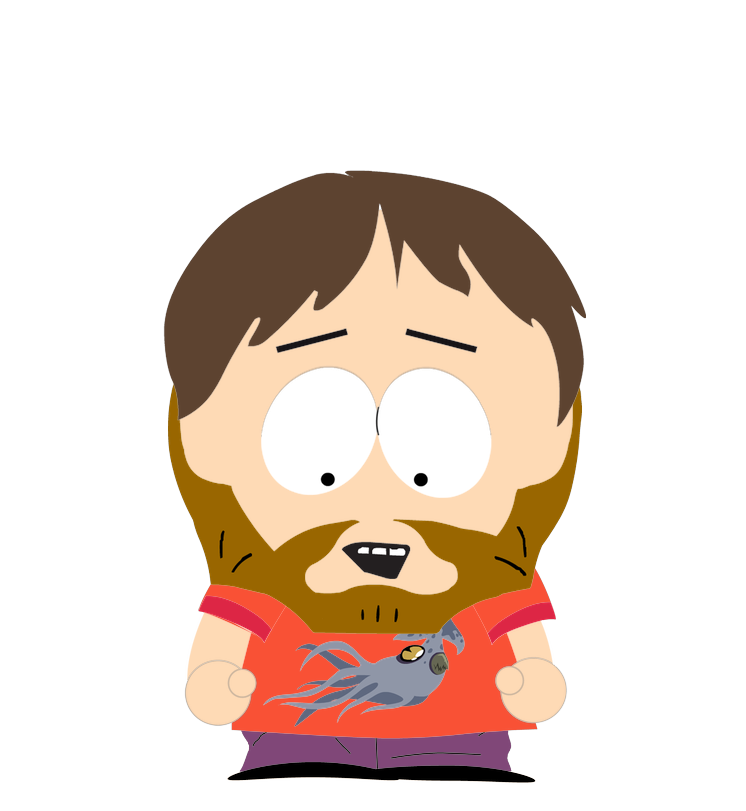

In [5]:
spag.generate(skin_colour = 0, 
               hair_colour = 6, 
               shirt_colour = 4,
               eyes = 17, 
               mouth = 3,
               has_beard = True,
               beard = 7,
               hair=5,
               shirt = 8, 
               trouser = 8)

# Generate multiples avatars :)

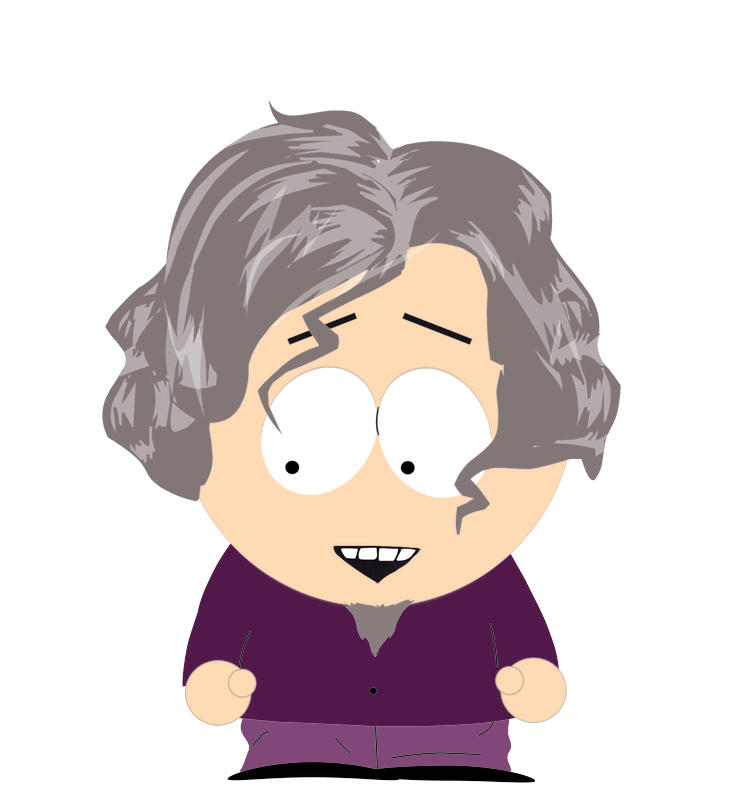

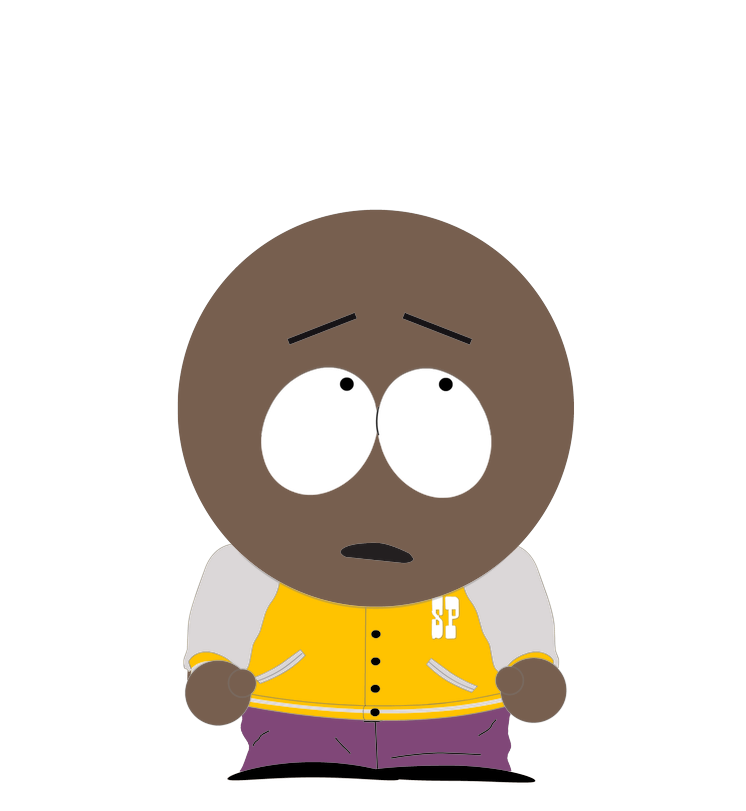

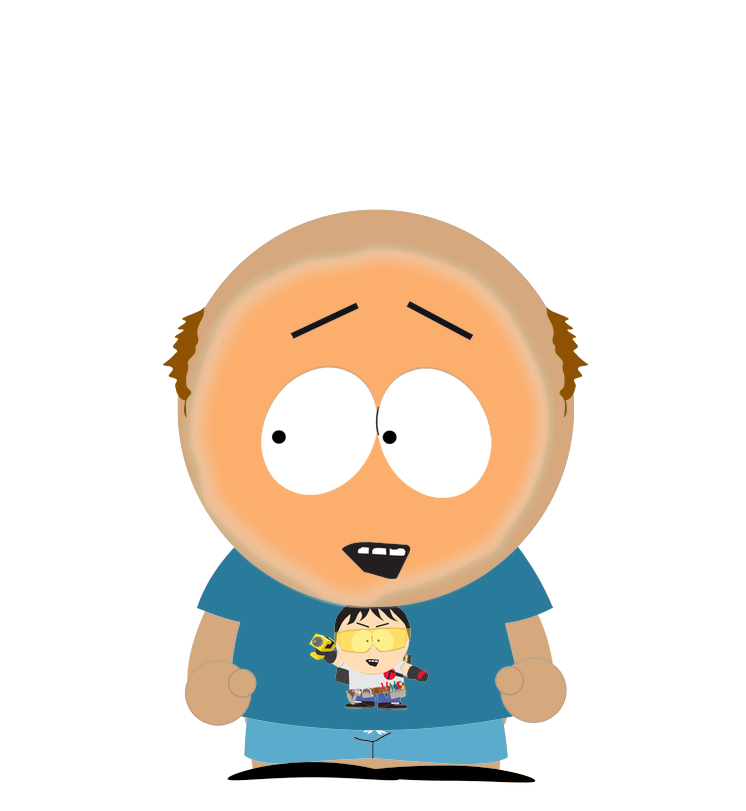

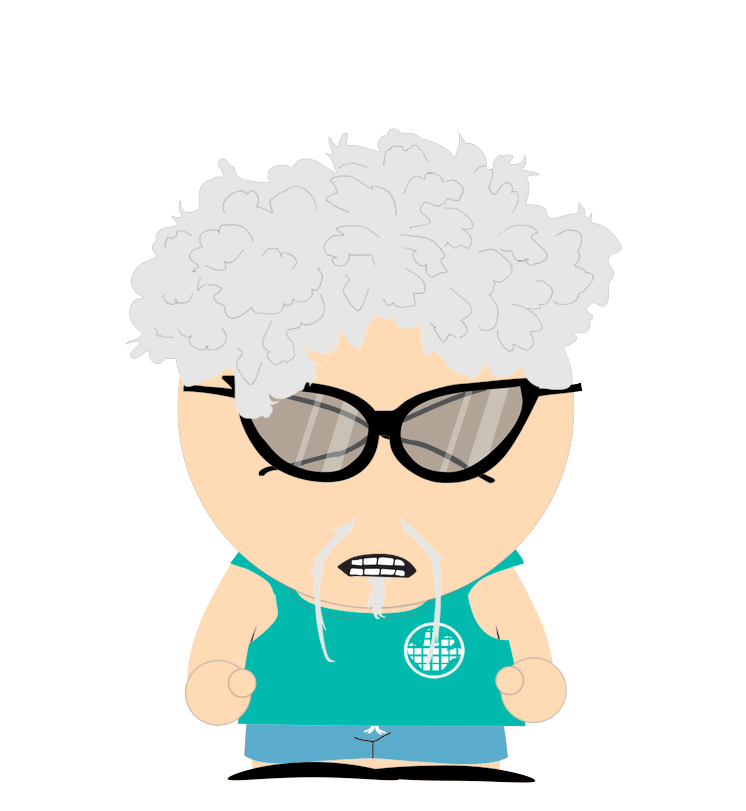

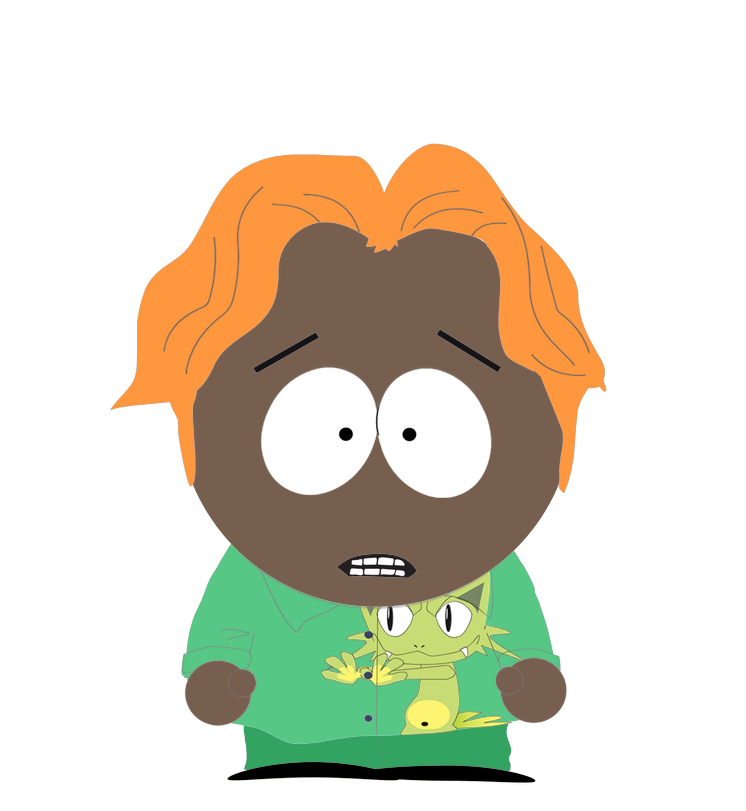

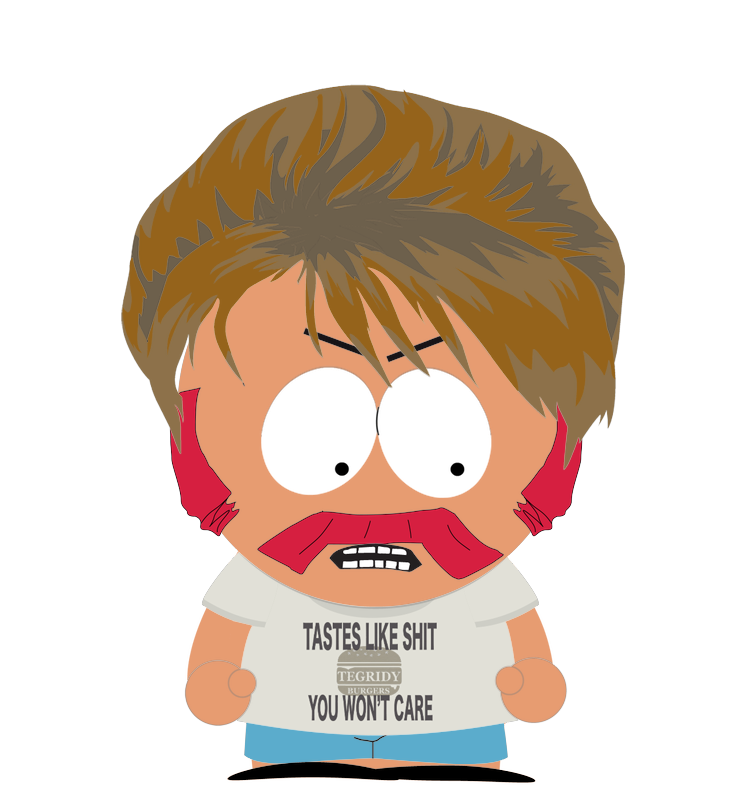

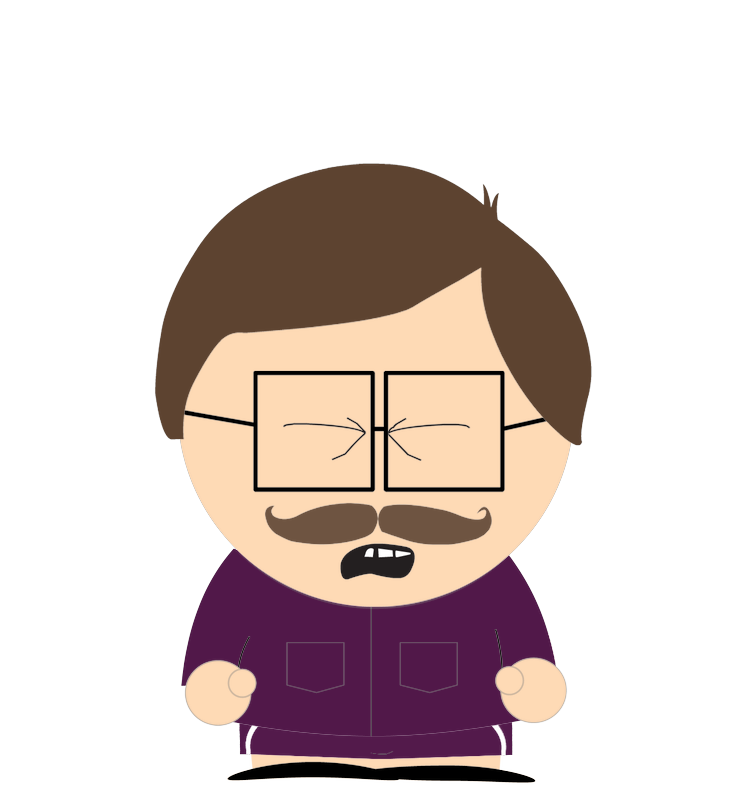

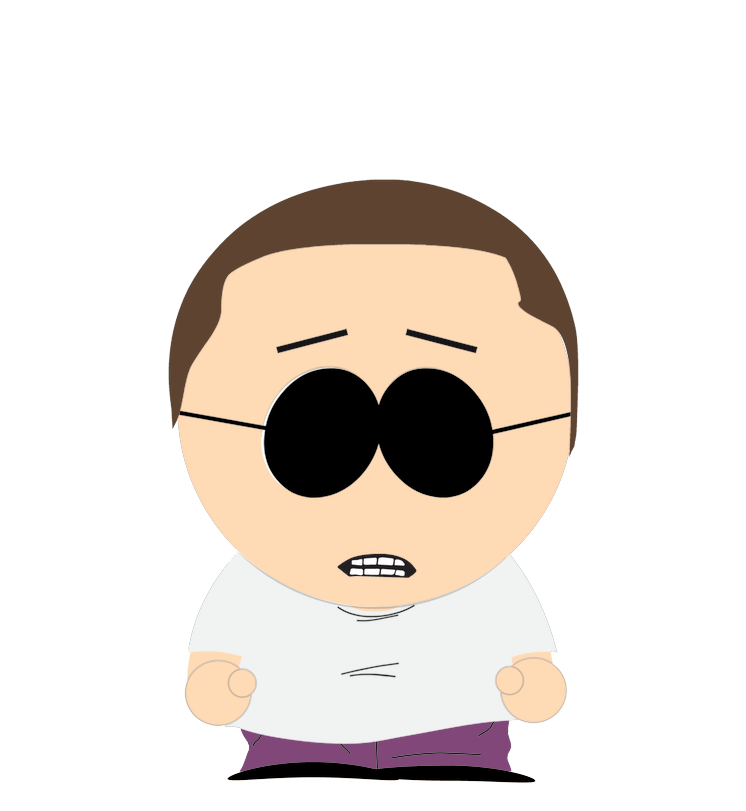

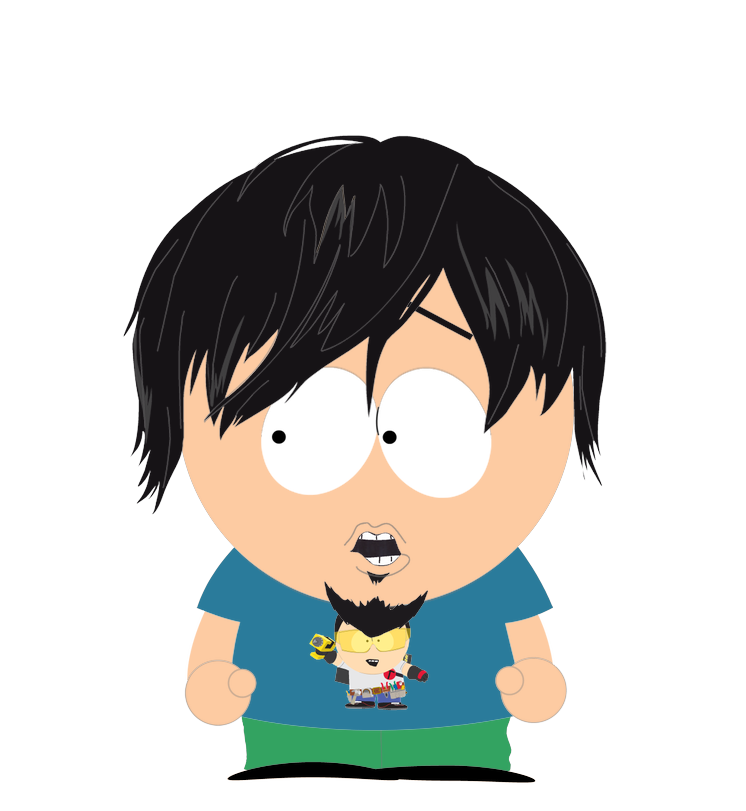

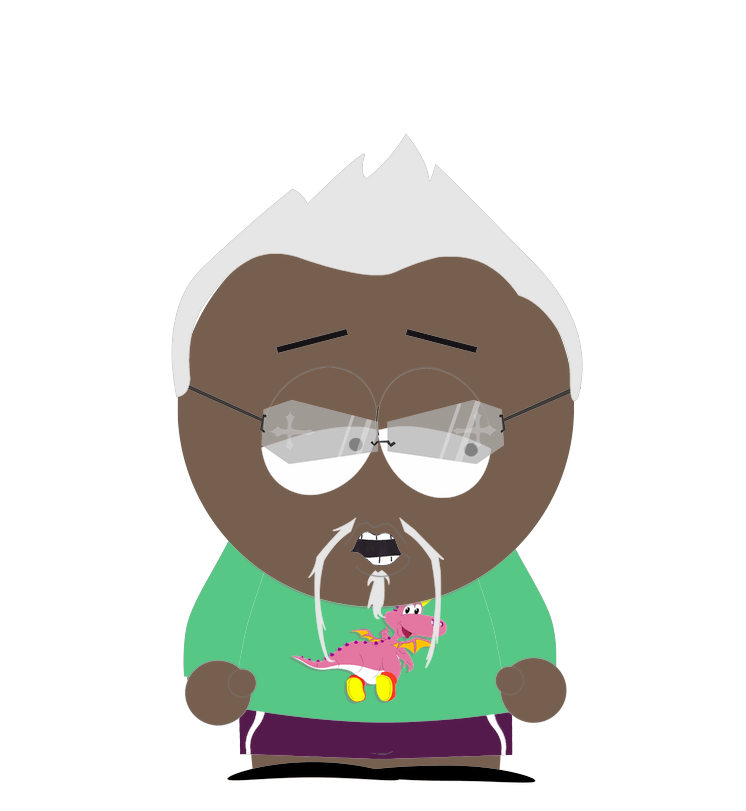

In [6]:
for i in range(10):
    img = spag.generate( )
    display(img)